In this notebook I am compiling the strategies I applied before: correcting the source model and adding the weak source as background to perform the fit

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
import matplotlib.pyplot as plt
import numpy as np
from regions import CircleSkyRegion
import yaml

from gammapy.catalog import CATALOG_REGISTRY
from gammapy.data import EventList
from gammapy.datasets import MapDataset
from gammapy.irf import PSFMap, EDispKernelMap
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    TemplateSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SuperExpCutoffPowerLaw4FGLSpectralModel,
    create_fermi_isotropic_diffuse_model,
    ExpCutoffPowerLawSpectralModel,
    TemplateSpectralModel,
)
from gammapy.modeling import Fit

In [2]:
##################################
# parameters I can change

dataset_idx = 1
n_bin_met = 5
thresh_idx = 20
###################################
# general definitions

dataset_names = ['low_energy', 'med_energy', 'hi_energy']
main_path = '/home/woody/caph/mppi062h/woody_output/final/fermilat/'
iso_list = ['iso_P8R3_ULTRACLEANVETO_V3_v1.txt', 'iso_P8R3_ULTRACLEANVETO_V3_v1.txt', 'iso_P8R3_SOURCE_V3_v1.txt']

N_bin_met = 8
radius_list = [12, 5, 5]
dataset_e_edges = [100, 600, 4e3, 1e6] #u.MeV

with open('source_list.txt') as f:
    source_list = f.readlines()
    
fgl = CATALOG_REGISTRY.get_cls("4fgl")()  

In [3]:
folder = f'{main_path}/{dataset_names[dataset_idx]}/{n_bin_met}_bin_met'
dataset = MapDataset.read(f'{folder}/fermi_dataset.fits')
dataset.background = Map.from_geom(geom=dataset.counts.geom, data=np.zeros_like(dataset.counts.data))   

dataset.mask_safe = Map.from_geom(geom=dataset.counts.geom, data=np.ones_like(dataset.counts.data).astype(bool))   
dataset.mask_safe &= dataset.counts.geom.region_mask(f"galactic;circle(0, 0, {radius_list[dataset_idx]})")

m1 = (dataset.counts.geom.axes['energy'].center.value > dataset_e_edges[dataset_idx])
m2 = (dataset.counts.geom.axes['energy'].center.value < dataset_e_edges[dataset_idx+1])
mask = m1 & m2
dataset.mask_safe.data[~mask] = 0

In [4]:
fermi_models = []

mo = fgl['4FGL J1745.6-2859'].sky_model()    
mo.spatial_model.parameters.freeze_all()
fermi_models.append(mo)
initial_model = fermi_models

filename='/home/vault/caph/mppi062h/repositories/GC/FermiLAT/gll_iem_v07.fits'
diffuse_galactic_fermi = Map.read(filename)
diffuse_galactic_fermi.unit = "cm-2 s-1 MeV-1 sr-1"
template_diffuse = TemplateSpatialModel(diffuse_galactic_fermi, normalize=False, filename=filename)

diffuse_iem = SkyModel(
    spectral_model=PowerLawNormSpectralModel(),
    spatial_model=template_diffuse,
    name="diffuse-iem",
)
initial_model.append(diffuse_iem)

filename = f'{main_path}/{dataset_names[dataset_idx]}/{iso_list[dataset_idx]}'
diffuse_iso = create_fermi_isotropic_diffuse_model(
filename=filename, interp_kwargs={"fill_value": None})
initial_model.append(diffuse_iso)
dataset.models = initial_model   

In [5]:
# opening the saved maps

for source_name in source_list[:thresh_idx]:
    if source_name[:-1] != '4FGL J1745.6-2859':
        temp = MapDataset.read(f'{folder}/sources_dataset/{source_name[5:-1]}.fits')
        dataset.background.data += temp.counts.data

In [6]:
result0= Fit().run(datasets=[dataset])
print(result0)
print(dataset.models)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 216
	total stat : 71725.73

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 216
	total stat : 71725.73


DatasetModels

Component 0: SkyModel

  Name                      : 4FGL J1745.6-2859
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   2.93e-12   +/- 5.1e-12 1 / (cm2 MeV s)
    reference    (frozen)   :   3975.235       MeV         
    alpha                   :      2.407   +/-    4.01             
    beta                    :      0.227   +/-    1.86             
    lon_0        (frozen)   :    266.415       deg         
    lat_0        (frozen)   :    -28.997       deg         



<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

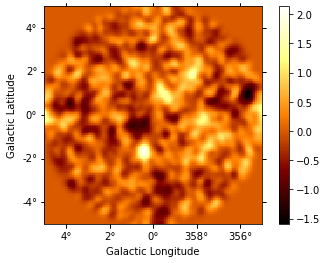

In [7]:
dataset.residuals('diff/sqrt(model)').sum_over_axes().smooth(2).plot(add_cbar=True)

In [8]:
from gammapy.estimators import ExcessMapEstimator

estimator = ExcessMapEstimator(
    correlation_radius="0.2 deg",
    selection_optional=[],
    energy_edges=[dataset_e_edges[dataset_idx], dataset_e_edges[dataset_idx+1]]*u.MeV,
)
result = estimator.run(dataset)

Position <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

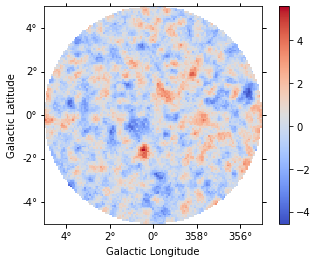

In [9]:
result["sqrt_ts"].plot(cmap="coolwarm", add_cbar=True)

/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/maps/wcs/ndmap.py:372: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow(data, **kwargs)


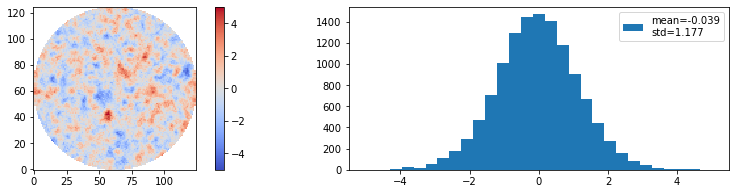

In [10]:
fig, ax = plt.subplots(1,2, figsize=(15, 3))
result["sqrt_ts"].plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ax=ax[0]);
data=result["sqrt_ts"].data.ravel()
ax[1].hist(data, bins=np.linspace(-5,5,30), label=f'mean={np.nanmean(data):.3f}\nstd={np.nanstd(data):.3f}');
plt.legend()

In [11]:
from gammapy.estimators import FluxPoints, FluxPointsEstimator

fp_central = FluxPointsEstimator(
    energy_edges=dataset.counts.geom.axes['energy'].edges,
    source='4FGL J1745.6-2859',
).run([dataset])

In [12]:
x_axis = hess.counts.geom.axes['energy'].center.value
energy_bounds = [0.01, 100] * u.TeV
sed_type = "e2dnde"

for s, fp in zip(['HESS J1745-290'], [fp_central]):
    plt.figure(figsize=(8, 6))

    ax = hess.models[s].spectral_model.plot(
        energy_bounds=energy_bounds, sed_type=sed_type, label="Model")
    hess.models[s].spectral_model.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type)
    fp.plot(ax=ax, sed_type=sed_type, label="HESS")
    ax.set_xlim(energy_bounds)
    plt.legend();

    plt.show()

NameError: name 'hess' is not defined

In [ ]:
name = 'fp_'+f'20220702_{hessera}_muoneff{muoneff_flag}_edisp{edisp}.fits'
#fp_central.write(name)